<a href="https://colab.research.google.com/github/erikroruiz/OCT_style_transfer/blob/main/test_oct_cycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Comprobar el entorno GPU

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


### Comprobar el entorno RAM

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


### Importar librerias

In [ ]:
import os
import cv2 
import calendar;
import time;
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from PIL import Image
from google.colab import drive
# from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

## Declarar las variables generales

In [ ]:
N_IMAGES_TEST = 5 # Número de imagenes a cargar de disco
EXPERIMENT_NAME = "cycleGAN_663c_663n_unpaired_bs1"

BUFFER_SIZE = 1
BATCH_SIZE = 1


# Test

In [ ]:
#Creamos la carpeta origen de Google Drive
BASE_FOLDER = '/content/drive/My Drive/TFM/'
# Montamos la carpeta en Google drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Cargamos los nombres de las imagenes completas que vamos a procesar 
images_names = [] 

for id in range(0,N_IMAGES_TEST):
    images_names.append(BASE_FOLDER+'datasets/test/images/L%0.2d.tif' % (id+1))

print ("Nombres de las imágenes a cargar:",type(images_names), len(images_names))
print (images_names)

Nombres de las imágenes a cargar: <class 'list'> 5
['/content/drive/My Drive/TFM/datasets/test/images/L01.tif', '/content/drive/My Drive/TFM/datasets/test/images/L02.tif', '/content/drive/My Drive/TFM/datasets/test/images/L03.tif', '/content/drive/My Drive/TFM/datasets/test/images/L04.tif', '/content/drive/My Drive/TFM/datasets/test/images/L05.tif']


In [ ]:
# Inicializamos los arrays
img_comp_array = np.int8(np.empty(shape=(N_IMAGES_TEST, 900, 300)))
recortes_array = np.int8(np.empty(shape=(int(N_IMAGES_TEST*3), 256, 256)))

print("===> Array con la imágenes completar ", img_comp_array.shape)
print("===> Array con los recortes de las imágenes completas despues de hacer el resize ", recortes_array.shape)

===> Array con la imágenes completar  (5, 900, 300)
===> Array con los recortes de las imágenes completas despues de hacer el resize  (15, 256, 256)


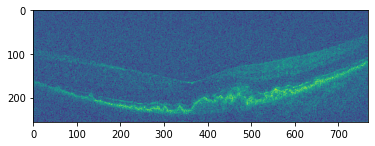

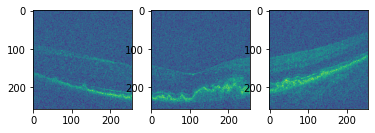

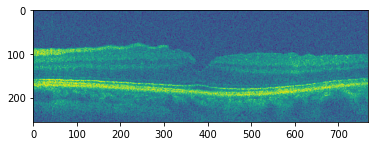

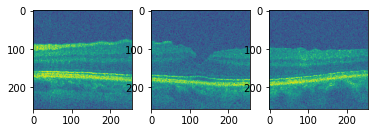

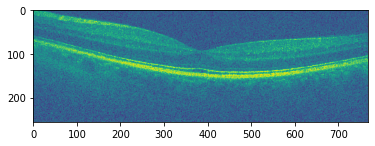

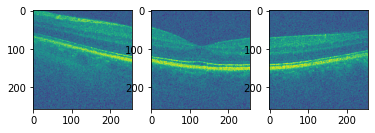

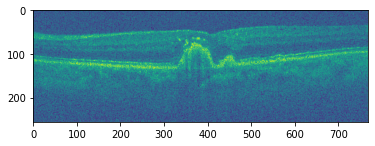

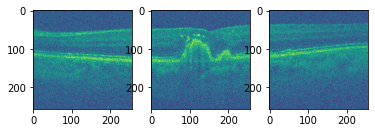

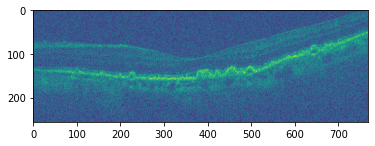

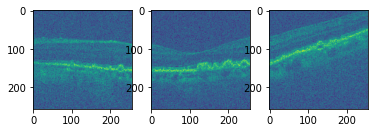

15
15


In [ ]:

list_test = [] # lista vacía
comp_images = [] # lista vacía
labels_0_test = [] # lista vacía

for i in range(0, N_IMAGES_TEST):

  img = cv2.imread(images_names[i], 0)

  # Resize a 768 x 256
  PIL_img = Image.fromarray(img)
  PIL_img = PIL_img.resize((768, 256), Image.ANTIALIAS)

  # recortes de 256 x 256
  # left, top, right, bottom: Esquina sup izq = (left, top), Esquina inf dcha = (right, bottom)
  PIL_patch1 = PIL_img.crop((0, 0, 256, 256))
  PIL_patch2 = PIL_img.crop((256, 0, 512, 256))
  PIL_patch3 = PIL_img.crop((512, 0, 768, 256))

  img = np.array(PIL_img)
  patch1 = np.array(PIL_patch1)
  patch2 = np.array(PIL_patch2)
  patch3 = np.array(PIL_patch3)

  plt.imshow(img)
  plt.show()

  plt.subplot(1, 3, 1)
  plt.imshow(patch1)
  plt.subplot(1, 3, 2)
  plt.imshow(patch2)
  plt.subplot(1, 3, 3)
  plt.imshow(patch3)

  plt.axis('on')
  plt.show()
  comp_images.append(PIL_img)
  list_test.append(cv2.cvtColor(np.uint8(patch1), cv2.COLOR_GRAY2BGR))
  list_test.append(cv2.cvtColor(np.uint8(patch2), cv2.COLOR_GRAY2BGR))
  list_test.append(cv2.cvtColor(np.uint8(patch3), cv2.COLOR_GRAY2BGR))

  labels_0_test.append(0)
  labels_0_test.append(0)
  labels_0_test.append(0)

print(len(list_test))
print(len(labels_0_test))

In [ ]:
# Creamos dos tf.dataset a partir de las listas de recortes con ruido
dataset_test = tf.data.Dataset.from_tensor_slices(list_test)
# Creamos un dataset de etiquetas a ceros 
labels_0_dataset_test = tf.data.Dataset.from_tensor_slices(labels_0_test)
# Añadimos las etiquetas al dataset
dataset_test = tf.data.Dataset.zip((dataset_test, labels_0_dataset_test))

print (type(dataset_test))

<class 'tensorflow.python.data.ops.dataset_ops.ZipDataset'>


tf.Tensor(15, shape=(), dtype=int64)
[Image] type: <class 'tensorflow.python.framework.ops.EagerTensor'> - shape: (256, 256, 3)
[Label] type: <class 'tensorflow.python.framework.ops.EagerTensor'> - shape: ()


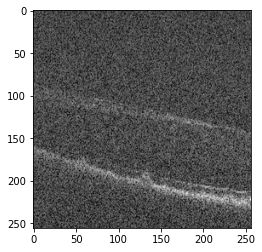

[Image] type: <class 'tensorflow.python.framework.ops.EagerTensor'> - shape: (256, 256, 3)
[Label] type: <class 'tensorflow.python.framework.ops.EagerTensor'> - shape: ()


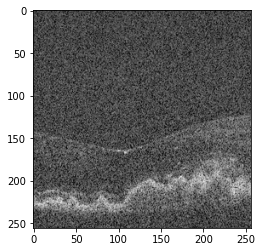

[Image] type: <class 'tensorflow.python.framework.ops.EagerTensor'> - shape: (256, 256, 3)
[Label] type: <class 'tensorflow.python.framework.ops.EagerTensor'> - shape: ()


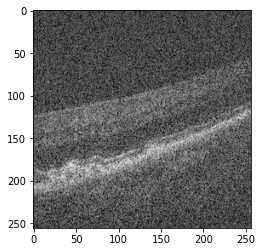

In [ ]:
# Visualizamos el dataset creado OCT
print(dataset_test.__len__())  
for image, label in dataset_test.take(3):
    print("[Image] type:",type(image),"- shape:",image.shape)
    print("[Label] type:",type(label),"- shape:",label.shape)
    plt.imshow(image)
    plt.show()

In [ ]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

def preprocess_image_test(image, label):
  image = normalize(image)
  return image

In [ ]:
# Apply the preprocessing operations to the test data
dataset_test = dataset_test.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

print(dataset_test.__len__())  

tf.Tensor(15, shape=(), dtype=int64)


In [ ]:
def generate_images(model, test_input):
  prediction = model(test_input)
    
  #Ploteamos la imágenes
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  ts = calendar.timegm(time.gmtime())

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    img = display_list[i] * 0.5 + 0.5
    plt.imshow(img)
    plt.axis('on')
    # Guardamos las imagenes en disco
    img_save = display_list[i].numpy() * 0.5 + 0.5
    img_save = Image.fromarray((img_save * 255).astype(np.uint8))
    filepath = ''
    if (i==1):
      filepath = BASE_FOLDER+''+EXPERIMENT_NAME+'/patches/'+str(ts)+'_.tif'
    # else:
    #   filepath = BASE_FOLDER+''+EXPERIMENT_NAME+'/images/'+str(ts)+'_C.tif'
      img_save.save(filepath)

  plt.show()

  return img_save


In [ ]:
def coser_img (lista, img_comp):
  img_comp.paste(lista[0], (0, 0))
  img_comp.paste(lista[1], (256, 0))
  img_comp.paste(lista[2], (512, 0))
  plt.imshow(img_comp)
  print(len(lista))
  return img_comp


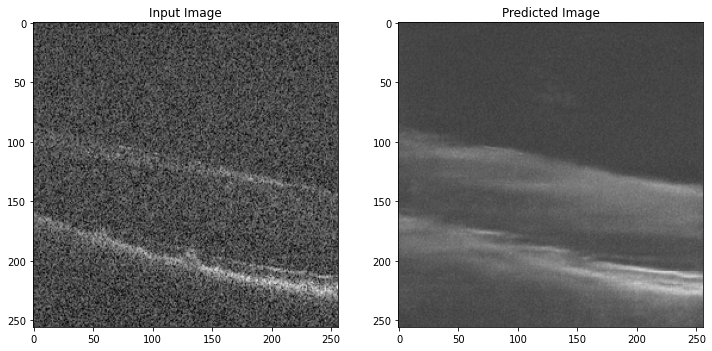

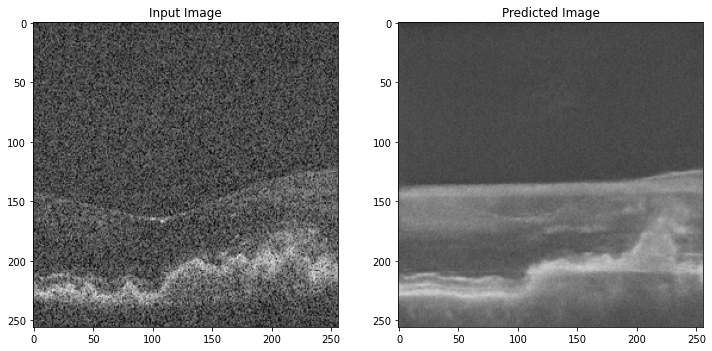

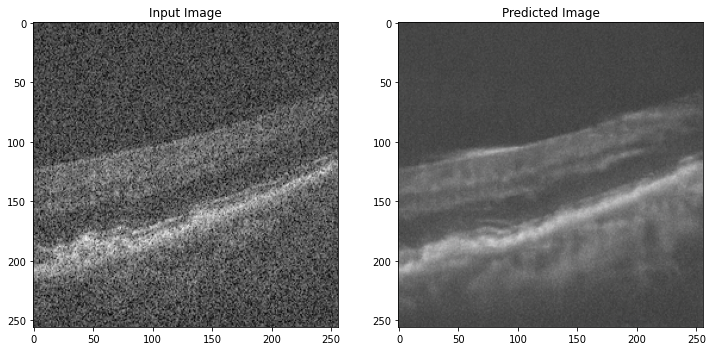

3


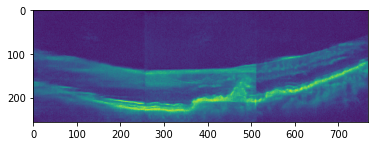

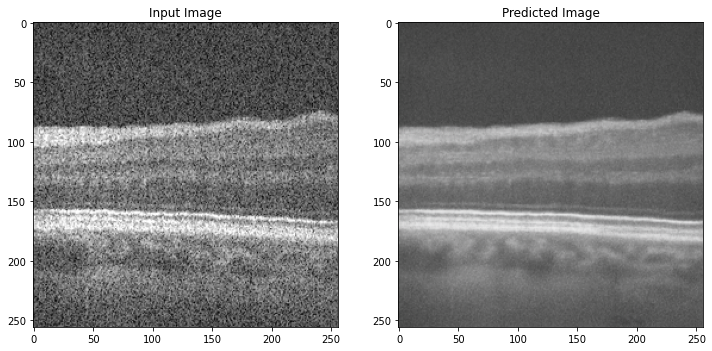

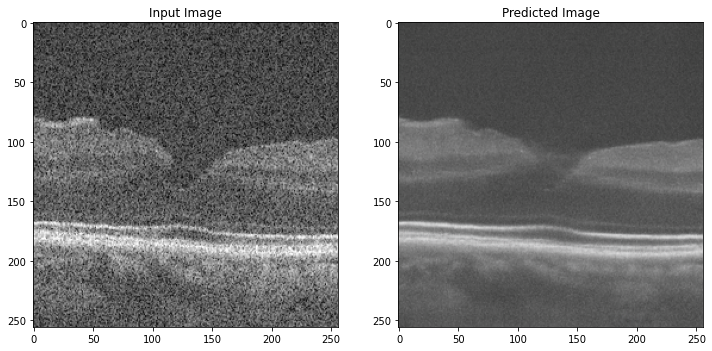

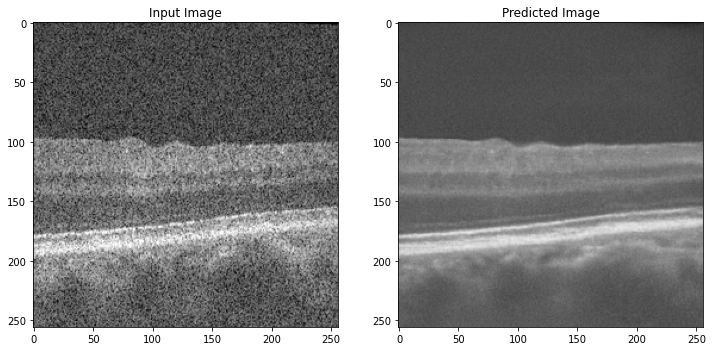

3


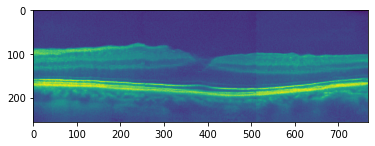

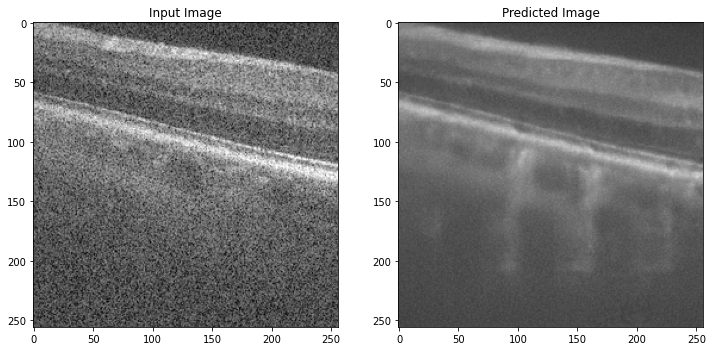

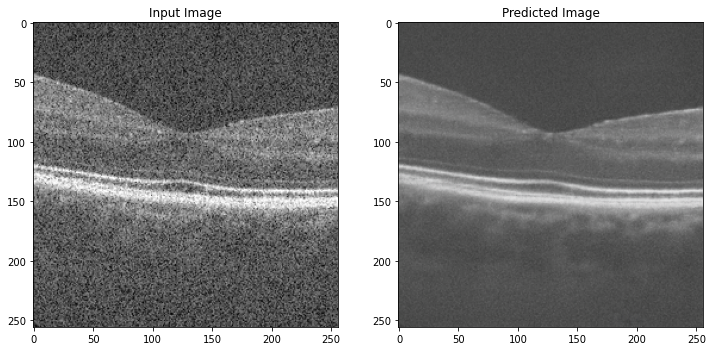

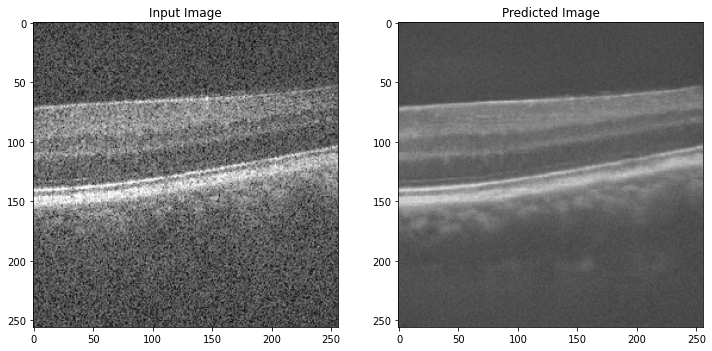

3


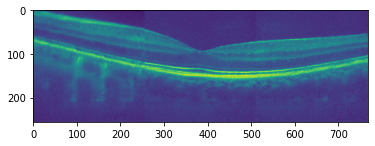

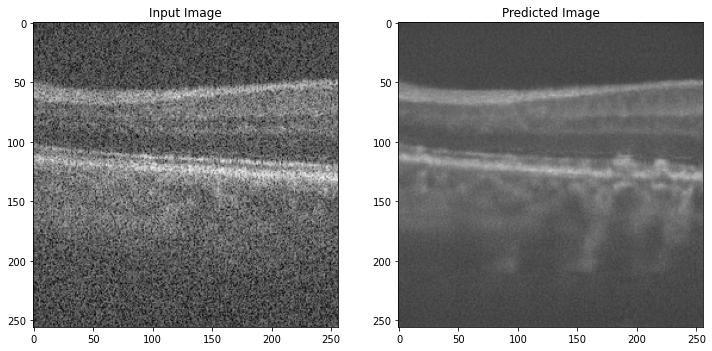

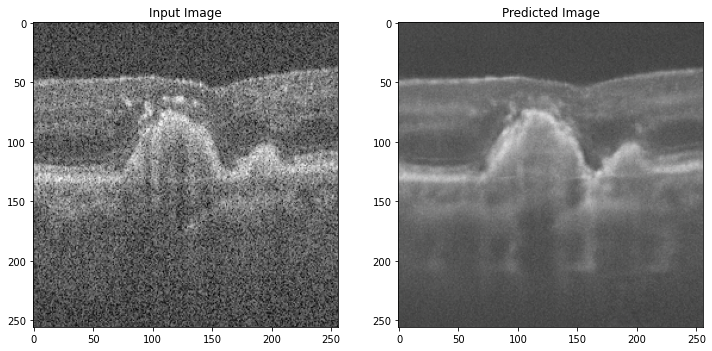

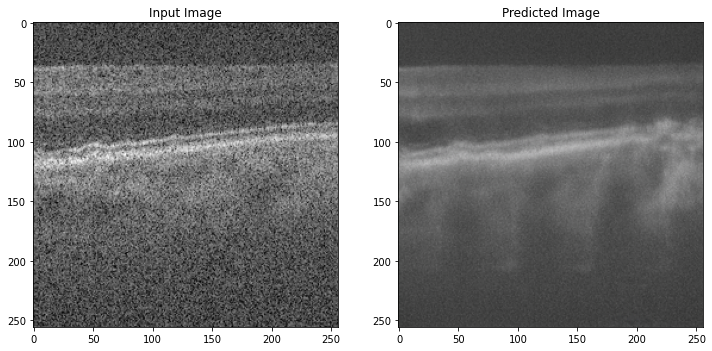

3


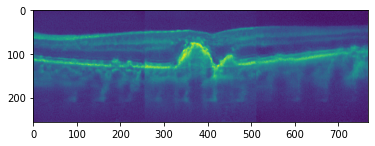

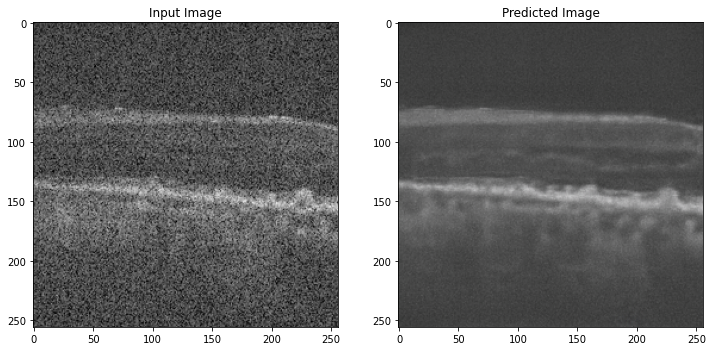

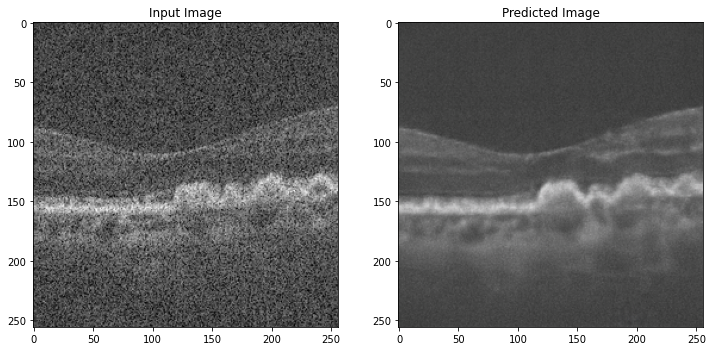

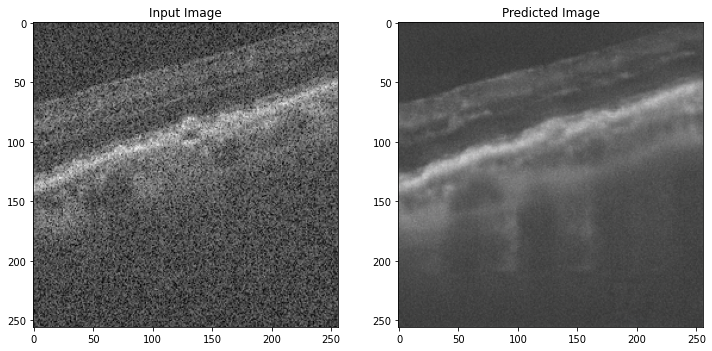

3


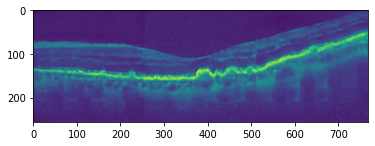

In [ ]:
# Cargamos el generador de disco
generator_g = tf.keras.models.load_model(BASE_FOLDER+''+EXPERIMENT_NAME+'/models')

# Run the trained model on the test dataset
cont=0
list_rec = [] # lista vacía
for inp in dataset_test.take(N_IMAGES_TEST*3):
  ts = calendar.timegm(time.gmtime())
  # print("[Image] type:",type(inp),"- shape:",inp.shape)
  gen_img = generate_images(generator_g, inp)
  # Cosemos la imagen
  if (cont<3):
      list_rec.append(gen_img)
      cont+=1
  if (cont == 3):
      cont = 0
      img_comp = coser_img(list_rec, comp_images[0])
      filepath = BASE_FOLDER+''+EXPERIMENT_NAME+'/images/'+str(ts)+'.tif'
      img_comp.save(filepath)
      list_rec = []

